
# iForestASD :  Unsupervised Anomaly Detection with Scikit-MultiFlow

Une implémentation de la détection d'anomalies non supervisée avec une forêt d'isolement dans Scikit-MultiFlow avec des fenêtres coulissantes et une détection de dérive

https://hal.archives-ouvertes.fr/hal-02874869v2/file/IForestASD_ScikitMultiflow_Version2_PourHAL.pdf

La première méthode proposée dans la catégorie basée sur l'isolement est Isolation forest (IForest)
L'une des limites d'IForest est qu'il a été conçu pour des jeux de données statiques et
pas pour le flux de données. Les auteurs proposent une amélioration d'IForest pour adapter
dans le contexte du flux de données à l'aide de fenêtres coulissantes. La méthode proposée est nommée
Algorithme de forêt d'isolement pour les données de flux (IForestASD).
Il existe d'autres améliorations et adaptations d'Isolation Forest telles que
forêt d'isolement étendue ou forêt d'isolement fonctionnelle mais elles sont
conçu pour les réglages par lots et non adapté pour le streaming de données.
Dans cette section nous présenterons l'algorithme IForest puis nous expliquerons
l'algorithme implémenté IForestASD.

https://pysad.readthedocs.io/en/latest/generated/pysad.models.IForestASD.html

Une approche de détection d'anomalies basée sur l'algorithme de forêt d'isolement pour diffuser des données à l'aide d'une fenêtre glissante. Notez que la dérive de concept n'est pas implémentée puisqu'elle fait partie de la simulation. Voir Algorithme 2 dans l'article "Une approche de détection d'anomalies basée sur l'algorithme de forêt d'isolement pour le streaming de données à l'aide d'une fenêtre glissante". Cette méthode n'est pas supervisée donc il n'est pas nécessaire de donner y comme paramètre.

#### Paramètres

         initial_window_X (np.float array of shape (num_initial_instances,num_features)) – La fenêtre initiale à adapter pour la période d'étalonnage initiale. Nous appliquons simplement fit à ces instances (Default=None).

         window_size (int) – La taille de la fenêtre de référence et son glissement (Default=2048).



#### References :

 - An Anomaly Detection Approach Based on Isolation Forest  for Streaming Data using Sliding Window (Ding \& Fei, 2013) https://www.sciencedirect.com/science/article/pii/S1474667016314999
 
 - Isolation-based Anomaly Detection (Liu, Ting \& Zhou, 2011) https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf

 - Scikit MultiFlow HalfSpace Trees Implementation - “Fast anomaly detection for streaming data,” in IJCAI Proceedings - S.C.Tan, K.M.Ting, and T.F.Liu, 
 https://scikit-multiflow.github.io/scikit-multiflow/_autosummary/skmultiflow.anomaly_detection.HalfSpaceTrees.html#id2

 - Original implementation of Isolation Forest (not the one in SK-learn) https://github.com/Divya-Bhargavi/isolation-forest



# Notebook File Structure  is the following

Part 1 - Main Class contians
  - Init,
  - Partial_fit,
  -  Update_model,
  - Predict methods which use the anomaly_score methods of the iForest class

Part 2 - Isolation Forest class (re-used) and main functions
 - 

Part 3 - Testing some examples and comparison of HS-Trees and IsolatationForestStream 
- on synthetic 
- on Real (HTTP) data.

## Import lib and packages

## Install Cyphion then load the Scikit-multiflow latest release from Github

In [0]:
## !pip install scikit-multiflow

In [0]:
!pip install -U git+https://github.com/scikit-multiflow/scikit-multiflow

  Cloning https://github.com/scikit-multiflow/scikit-multiflow to /tmp/pip-req-build-xxdzzk48
  Running command git clone -q https://github.com/scikit-multiflow/scikit-multiflow /tmp/pip-req-build-xxdzzk48
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.5.dev0-cp36-cp36m-linux_x86_64.whl size=947488 sha256=822586e0ddac2d9fcd2edfbba9353083b2492cde3ccffeb70ceccec135c96643
  Stored in directory: /tmp/pip-ephem-wheel-cache-r8p6npo3/wheels/45/77/32/db97a8965573a1da8d6eb430c3ac6ebca714e7ab156c15912a
Successfully built scikit-multiflow


In [2]:
from skmultiflow import *

In [3]:
from skmultiflow.core import BaseSKMObject, ClassifierMixin
from skmultiflow.utils import check_random_state
from skmultiflow.utils import get_dimensions
import numpy as np
import pandas as pd
import random
from sklearn.metrics import confusion_matrix
import sys
import time

# Part 1 - Main class - IsolationForestStream

Ce code implémente une approche de détection d'anomalies basée sur l'algorithme de forêt d'isolement pour diffuser des données à l'aide d'une fenêtre glissante (Ding \& Fei, 2013) [3]

    Chaque échantillon a un score d'anomalie calculé sur la base de l'approche basée sur les anomalies de la forêt d'isolement [2]. Le concept de forêt d'isolement [1]
    consiste à isoler les observations en sélectionnant aléatoirement une caractéristique
    puis en sélectionnant au hasard une valeur de partage entre le maximum et le minimum
    valeurs de la fonction sélectionnée.
    
    Le modèle est mis à jour lorsqu'une dérive a été détectée en fonction d'un seuil de dérive d'entrée. L'approche de détection de dérive est proposée par [2]
    et fonctionne comme suit : si le score d'anomalie moyenné entre deux fenêtres glissantes successives est supérieur au seuil de dérive (u),
    Ensuite, le modèle précédent est complètement supprimé et un nouveau modèle est construit en tant que forêt d'isolation sur le dernier flux de fenêtres coulissantes.


####  Paramètres

    n_estimators : int, optionnel (défaut=25)
       Nombre d'arbres dans l'ensemble.
       't' dans le papier original.

    taille_fenêtre : entier, facultatif (défaut=100)
        La taille de la fenêtre du flux.
        ψ, 'Psi' dans l'article original.

#### Optionnel

    anomaly_threshold : double, facultatif (défaut=0,5)
        Le seuil de déclaration des anomalies.
        Toute probabilité de prédiction d'instance supérieure à ce seuil sera déclarée comme une anomalie.

    drift_threshold : double, facultatif (défaut=0,5)
        Le seuil pour détecter la dérive et mettre à jour le modèle.

       Si le score d'anomalie moyen entre deux fenêtres glissantes successives est supérieur au seuil (u),
    Ensuite, le modèle précédent est complètement supprimé et un nouveau modèle est construit en tant que forêt d'isolation sur le dernier flux de fenêtres coulissantes.
    Ce paramètre est censé être connu par un domaine expert, en fonction du jeu de données.

#### Autres attributs

    ensemble : Ensemble d'arbres d'isolement
        Contenir un objet Isolation Tree Ensemble, modèle actuel pour IsolationForestStream

    taille_échantillon : entier
        Nombre d'échantillons vus depuis la mise à jour

    taux_anomalie : float
        Taux des anomalies dans la fenêtre glissante précédente (AnomalyRate dans l'original papier iForestASD)

    prec_window & window : numpy.ndarray de forme (n_samples, self.window_size)
        La fenêtre de données précédente et actuelle

    cpt : int
        Compteur, si le n_estimator est supérieur à son, il conviendra


#### References

    [1] Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua.        
“Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.

    [2] Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation-based anomaly detection.” ACM Transactions on Knowledge Discovery from Data (TKDD) 6.1 (2012): 
self.n_estimators

    [3] Ding, Zhiguo. (2013) An Anomaly Detection Approach Based on Isolation Forest Algorithm for Streaming Data Using Sliding Window. 12-17. 10.3182/20130902-3-CN-3020.00044. 

In [4]:
##  Edition du fichier iforestasd_scikitmultiflow.py .

class IsolationForestStream(BaseSKMObject, ClassifierMixin):

  def __init__(self, window_size=100, n_estimators=25, anomaly_threshold=0.5, drift_threshold=0.5, random_state=None):
    
        super().__init__()

        self.n_estimators = n_estimators
        self.ensemble = None      
        self.random_state = random_state
        self.window_size = window_size
        self.samples_seen = 0
        self.anomaly_rate = 0.20 
        self.anomaly_threshold = anomaly_threshold
        self.drift_threshold = drift_threshold
        self.window = None
        self.prec_window = None
        self.cpt = 0


  def partial_fit(self, X, y, classes=None, sample_weight=None):

          """ Partially (incrementally) fit the model.
          Parameters
          ----------
          X : numpy.ndarray of shape (n_samples, n_features)
              The features to train the model.
          y: numpy.ndarray of shape (n_samples)
              An array-like with the class labels of all samples in X.
          classes: None
              Not used by this method.
          sample_weight: None
              Not used by this method.
          Returns
          -------
          self
          """

          ## get the number of observations
          number_instances, _ = X.shape
          
          if(self.samples_seen==0):
            ## ToDo ? Give a sample of self.window_size in attribute of iForest
            iforest = IsolationTreeEnsemble(self.window_size,self.n_estimators,self.random_state)
            self.ensemble = iforest

          
          for i in range(number_instances):
              self._partial_fit(X[i], y[i])

          return self


  def _partial_fit(self, X, y):

          """ Trains the model on samples X and corresponding targets y.
          Private function where actual training is carried on.
          Parameters
          ----------
          X: numpy.ndarray of shape (1, n_features)
              Instance attributes.
          y: int
              Class label for sample X. Not used in this implementaion which is Unsupervised
          """ 
          
          """
          Reshape X and add it to our window if it isn't full.
          If it's full, give window to our precedent_window.
          If we are at the end our window, fit if we're learning 
          Check the anomaly score of our window 
          Update if self.anomaly_rate > self.drift_threshold

          """
          X = np.reshape(X,(1,len(X)))

          if self.samples_seen % self.window_size == 0:
            ## Update the two windows (precedent one and current windows)
            self.prec_window = self.window
            self.window = X
          else:
            self.window = np.concatenate((self.window,X))
          

          if self.samples_seen % self.window_size == 0 and self.samples_seen !=0:
              #Fit the ensemble if it's not empty
              if(self.cpt<self.n_estimators):
                self.ensemble.fit(self.prec_window)
                self.cpt += 1                  
                  ## Update the current anomaly score
              self.anomaly_rate = self.anomaly_scores_rate(self.prec_window) ## Anomaly rate
              #print(self.anomaly_rate) ## 

                  ## Update the model if the anomaly rate is greater than the threshold (u in the original paper [3])
              if self.anomaly_rate > self.drift_threshold: ## Use Anomaly RATE ?
                self.update_model(self.prec_window) # This function will discard completly the old model and create a new one

          self.samples_seen += 1
          
  def update_model(self,window):
    """ Update the model (fit a new isolation forst) if outhe current anomaly rate (in the previous sliding window)
     is higher than self.drift_threshold
        Parameters: 
          window: numpy.ndarray of shape (self.window_size, n_features)
        Re-Initialize our attributes and our ensemble, fit with the current window

    """

    ## ToDo ? Give a sample of self.window_size in attribute of iForest
    self.is_learning_phase_on = True
    iforest = IsolationTreeEnsemble(self.window_size,self.n_estimators,self.random_state)
    self.ensemble = iforest
    self.ensemble.fit(window)
    print("Update")
    #sow 11052022
    #print("iForest ASD Update the model by training a new iForest")
    
          
  def anomaly_scores_rate(self, window):
    """
    Given a 2D matrix of observations, compute the anomaly rate 
    for all instances in the window and return an anomaly rate of the given window.

    Parameters :
    window: numpy.ndarray of shape (self.window_size, n_features)
    """

    score_tab = 2.0 ** (-1.0 * self.ensemble.path_length(window) / c(len(window)))
    score = 0
    for x in score_tab:
      if x > self.anomaly_threshold:
        score += 1
    return score / len(score_tab)
    
  def predict(self, X):
    """
    Given an instance, Predict the anomaly (1 or 0) based on the last sample of the window by using predict_proba if our model have fit, 
    else return None

    """
    if(self.samples_seen <= self.window_size):

      return [-1] ## Return the last element

    X = np.reshape(X,(1,len(X[0])))
    self.prec_window = np.concatenate((self.prec_window ,X)) ## Append the instances in the sliding window

    prediction =  self.ensemble.predict_from_anomaly_scores(self.predict_proba(self.prec_window),self.anomaly_threshold) ## return 0 or 1

    return [prediction]
              
  def predict_proba(self, X):
    """
    Calculate the anomaly score of the window if our model have fit, else return None
    Parameters :
    X: numpy.ndarray of shape (self.window_size, n_features)   

    """
    if(self.samples_seen <= self.window_size):
        return [-1]
    return self.ensemble.anomaly_score(self.prec_window)[-1] # Anomaly return an array with all scores of each data, taking -1 return the last instance (X) anomaly score
    

# Part 2- IsolationTreeEnsemble  Class (iForest in the original paper)

L'objectif de ce projet est de mettre en œuvre l'algorithme original de la forêt d'isolement de Fei Tony Liu, Kai Ming Ting et Zhi-Hua Zhou. (Une version ultérieure de ce travail est également disponible : détection d'anomalies basée sur l'isolement.) Il existe deux approches générales pour la détection d'anomalies :

     - modéliser à quoi ressemble la normale, puis rechercher des observations 
     non normales
     - se concentrer sur les anomalies, qui sont peu nombreuses et différentes. C'est l'approche intéressante et relativement nouvelle adoptée par les auteurs 
     des forêts d'isolement.

L'algorithme de la forêt d'isolement est original et beau dans sa simplicité ; et semble également très bien fonctionner, avec quelques faiblesses connues. Le document académique est extrêmement lisible, c'est donc le meilleur début pour tout savoir.

Référence

https://github.com/Divya-Bhargavi/isolation-forest

In [5]:
# Follows original paper algo from https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf
# Original Source re-used and adpted to our project from https://github.com/Divya-Bhargavi/isolation-forest 
Edition du fichier iforestSow.py

class IsolationTreeEnsemble:
    def __init__(self, sample_size, n_trees, random_state):
        self.sample_size = sample_size
        self.n_trees = n_trees
        self.depth = np.log2(sample_size)
        self.trees = []
        self.random_state = random_state
        self._random_state = check_random_state(self.random_state)
        self.is_learning_phase_on = True 

    def fit(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, create an ensemble of IsolationTree
        objects and store them in a list: self.trees.  Convert DataFrames to
        ndarray objects.
        """
        len_x = len(X)

        for i in range(self.n_trees):
            sample_idx = random.sample(list(range(len_x)), self.sample_size )
            temp_tree = IsolationTree(self.depth, 0).fit(X[sample_idx])
            self.trees.append(temp_tree)

        return self
   
    def path_length(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, X, compute the average path length
        for each observation in X.  Compute the path length for x_i using every
        tree in self.trees then compute the average for each x_i.  Return an
        ndarray of shape (len(X),1).
        """
        pl_vector = []

        for x in (X):
            pl = np.array([path_length_tree(x, t, 0) for t in self.trees])
            pl = pl.mean()

            pl_vector.append(pl)

        pl_vector = np.array(pl_vector).reshape(-1, 1)

        return pl_vector

    def anomaly_score(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """
        return 2.0 ** (-1.0 * self.path_length(X) / c(len(X)))

    def predict_from_anomaly_scores(self, scores:int, threshold:float):
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """
        predictions = 1 if scores >= threshold else 0

        return predictions


class IsolationTree:
    def __init__(self, height_limit, current_height):

        self.depth = height_limit
        self.current_height = current_height
        self.split_by = None
        self.split_value = None
        self.right = None
        self.left = None
        self.size = 0
        self.exnodes = 0
        self.n_nodes = 1

    def fit(self, X:np.ndarray):
        """
        Given a 2D matrix of observations, create an isolation tree. Set field
        self.root to the root of that tree and return it.
        If you are working on an improved algorithm, check parameter "improved"
        and switch to your new functionality else fall back on your original code.
        """

        if len(X) <= 1 or self.current_height >= self.depth:
            self.exnodes = 1
            self.size = X.shape[0]

            return self

        split_by = random.choice(np.arange(X.shape[1]))
        X_col = X[:, split_by]
        min_x = X_col.min()
        max_x = X_col.max()

        if min_x == max_x:
            self.exnodes = 1
            self.size = len(X)

            return self

        else:

            split_value = min_x + random.betavariate(0.5, 0.5) * (max_x - min_x)

            w = np.where(X_col < split_value, True, False)
            del X_col

            self.size = X.shape[0]
            self.split_by = split_by
            self.split_value = split_value

            self.left = IsolationTree(self.depth, self.current_height + 1).fit(X[w])
            self.right = IsolationTree(self.depth, self.current_height + 1).fit(X[~w])
            self.n_nodes = self.left.n_nodes + self.right.n_nodes + 1

        return self

def c(n):
    if n > 2:
        return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))
    elif n == 2:
        return 1
    if n == 1:
        return 0

def path_length_tree(x, t,e):
    e = e
    if t.exnodes == 1:
        e = e+ c(t.size)
        return e
    else:
        a = t.split_by
        if x[a] < t.split_value :
            return path_length_tree(x, t.left, e+1)
        if x[a] >= t.split_value :
            return path_length_tree(x, t.right, e+1)        

# Part 3 - Experiments and results comparisons HS-Trees vs IsolationForestStream

Half-Space Tree, connu sous le nom de HSTree, est une structure de données efficace pour détecter les anomalies dans les données en continu. Il est robuste lorsque les données entrantes sont infinies et contiennent une grande quantité de données normales. HSTree a une complexité temporelle amortie constante et un besoin constant en mémoire lors du traitement des données. Il a également une précision de détection robuste lorsque les paramètres sont différents.

Ce référentiel contient mon implémentation de la structure de données HSTree et des tests avec des données HTML et SMTP. L'implémentation est en Python3 et l'idée de HSTree est basée sur les recherches de Tan, Ting et Liu[1].

Référence


https://github.com/yli96/HSTree


## Simple and Fast example, 10 window base on 100 sample

<IPython.core.display.Javascript object>


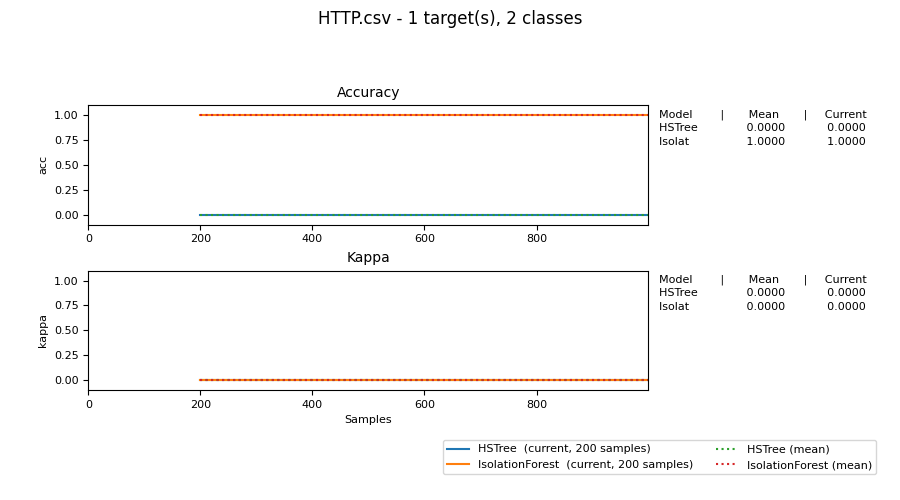

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [457.50s]
Processed samples: 1000
Mean performance:
HSTree - Accuracy     : 0.0000
HSTree - Kappa        : 0.0000
IsolationForest - Accuracy     : 1.0000
IsolationForest - Kappa        : 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, random_state=5,
                size_limit=10.0, window_size=10),
 IsolationForestStream(anomaly_threshold=0.9, drift_threshold=0.5,
                       n_estimators=100, random_state=None, window_size=10)]

In [6]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
#from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream

stream = FileStream('/home/mamadou/big-data/cerin24022022/py-mariambarry/iForestASD_Streaming_Scikit-MultiFlow/Notebook_24032020_2325/datasets/HTTP.csv', n_targets=1, target_idx=-1)
#stream = FileStream('/Users/zhansaya/Downloads/dataset_https.csv', n_targets=1, target_idx=-1)
#stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use

stream.prepare_for_use()
# 2. Instantiate the 2 classifier for comparisons
h = [HalfSpaceTrees(
    #n_features=stream.n_features, 
    window_size=10, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5),
     
    IsolationForestStream(
    window_size=10, n_estimators=100, anomaly_threshold=0.9, drift_threshold=0.5, random_state=None)]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=100, max_samples=1000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])


REAL DATA




/home/mamadou/.local/lib/python3.8/site-packages/skmultiflow/data/base_stream.py:191: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  warnings.warn(


<IPython.core.display.Javascript object>


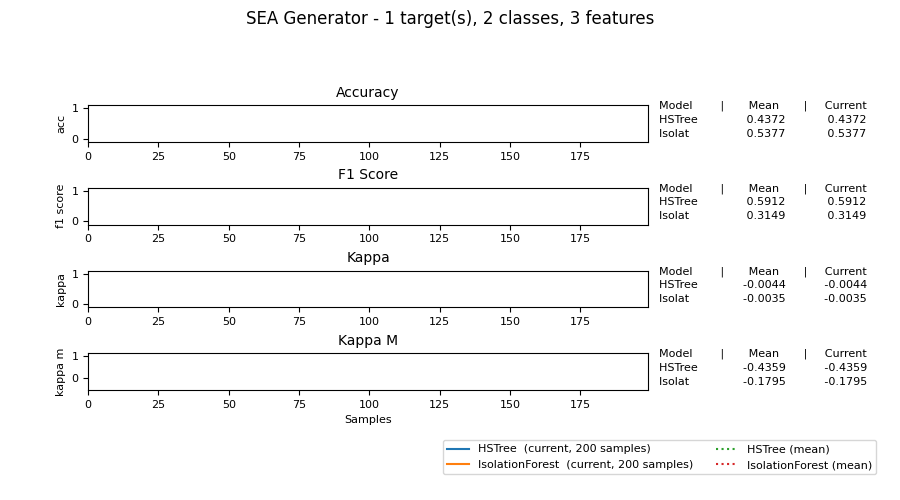

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1 sample(s).
Evaluating...
 #################### [100%] [14.93s]
Processed samples: 200
Mean performance:
HSTree - Accuracy     : 0.4372
HSTree - Kappa        : -0.0044
HSTree - Kappa M      : -0.4359
HSTree - F1 score: 0.5912
IsolationForest - Accuracy     : 0.5377
IsolationForest - Kappa        : -0.0035
IsolationForest - Kappa M      : -0.1795
IsolationForest - F1 score: 0.3149


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, random_state=5,
                size_limit=10.0, window_size=10),
 IsolationForestStream(anomaly_threshold=0.7, drift_threshold=0.5,
                       n_estimators=10, random_state=None, window_size=10)]

In [11]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
#from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream

stream = FileStream('/home/mamadou/big-data/cerin24022022/py-mariambarry/iForestASD_Streaming_Scikit-MultiFlow/Notebook_24032020_2325/datasets/HTTP.csv', n_targets=1, target_idx=-1)
#stream = FileStream('dataset_https.csv', n_targets=1, target_idx=-1)
stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use

stream.prepare_for_use()
# 2. Instantiate the 2 classifier for comparisons
h = [HalfSpaceTrees(
    #n_features=stream.n_features, 
    window_size=10, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5),
     
    IsolationForestStream(
    window_size=10, n_estimators=10, anomaly_threshold=0.7, drift_threshold=0.5, random_state=None)]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1, max_samples=200, show_plot=True, metrics=['accuracy','F1', 'kappa', 'kappa_m'],  batch_size=1)
#evaluator = EvaluatePrequential(pretrain_size=1, max_samples=20, show_plot=True, metrics=['accuracy','F1', 'kappa', 'kappa_m'], batch_size=1, output_file = 'results_test.csv')
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])


## Evaluator with PREQUENTIAL F1 AND KAPPA AND KAPPA_m

La méthode différée d'évaluation préquentielle.

L'évaluation préquentielle retardée est conçue spécifiquement pour les paramètres de flux, dans le sens où chaque échantillon sert à deux fins, et que les échantillons sont analysés séquentiellement, par ordre d'arrivée, et sont utilisés pour mettre à jour le modèle uniquement lorsque leur étiquette est disponible, compte tenu de leurs horodatages. (heures d'arrivée et de disponibilité).

Cette méthode consiste à utiliser chaque échantillon pour tester le modèle, c'est-à-dire faire des prédictions, puis le même échantillon est utilisé pour entraîner le modèle (ajustement partiel) après que son étiquette soit disponible après un certain délai. De cette façon, le modèle est toujours testé sur des échantillons qu'il n'a pas encore vus et mis à jour sur des échantillons dont les étiquettes sont disponibles.

<IPython.core.display.Javascript object>


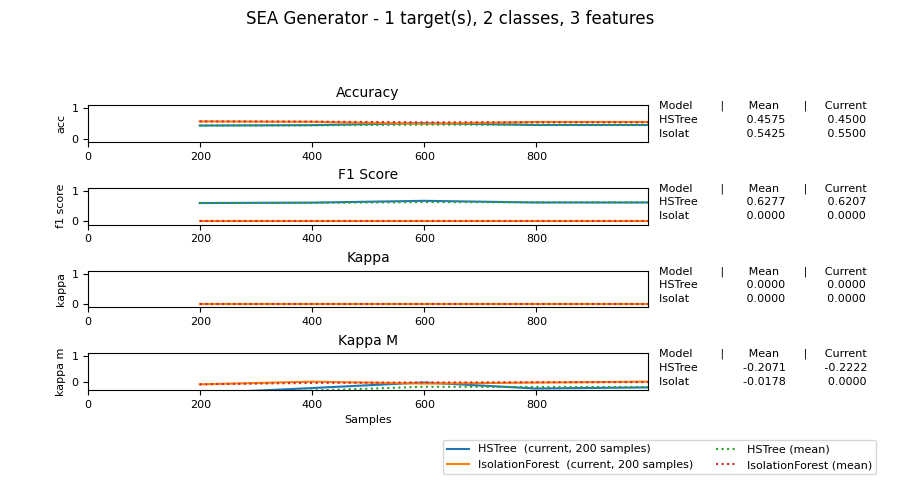

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1 sample(s).
Evaluating...
 #################### [100%] [61.44s]
Processed samples: 1000
Mean performance:
HSTree - Accuracy     : 0.4575
HSTree - Kappa        : 0.0000
HSTree - Kappa M      : -0.2071
HSTree - F1 score: 0.6277
IsolationForest - Accuracy     : 0.5425
IsolationForest - Kappa        : 0.0000
IsolationForest - Kappa M      : -0.0178
IsolationForest - F1 score: 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, random_state=5,
                size_limit=10.0, window_size=10),
 IsolationForestStream(anomaly_threshold=0.7, drift_threshold=0.5,
                       n_estimators=10, random_state=None, window_size=10)]

In [12]:
# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1, max_samples=1000, show_plot=True, 
                                metrics=['accuracy','F1', 'kappa', 'kappa_m'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])



<IPython.core.display.Javascript object>


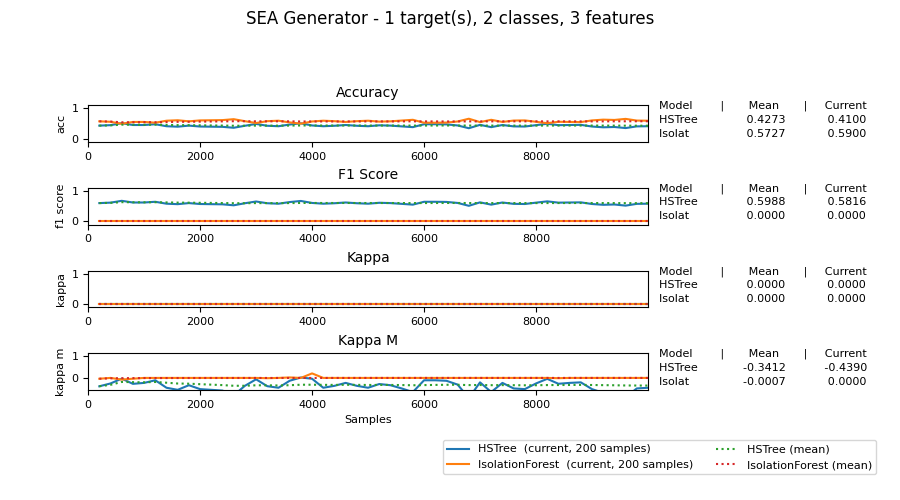

Prequential Evaluation
Evaluating 1 target(s).
Evaluating...
 #################### [100%] [598.14s]
Processed samples: 10000
Mean performance:
HSTree - Accuracy     : 0.4273
HSTree - Kappa        : 0.0000
HSTree - Kappa M      : -0.3412
HSTree - F1 score: 0.5988
IsolationForest - Accuracy     : 0.5727
IsolationForest - Kappa        : 0.0000
IsolationForest - Kappa M      : -0.0007
IsolationForest - F1 score: 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, random_state=5,
                size_limit=10.0, window_size=10),
 IsolationForestStream(anomaly_threshold=0.7, drift_threshold=0.5,
                       n_estimators=10, random_state=None, window_size=10)]

In [13]:
# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=0, max_samples=10000, show_plot=True, 
                                metrics=['accuracy','F1', 'kappa', 'kappa_m'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])



## Experiment 5 in slides - 10000 samples, 100 window_size, 50 estimators

<IPython.core.display.Javascript object>


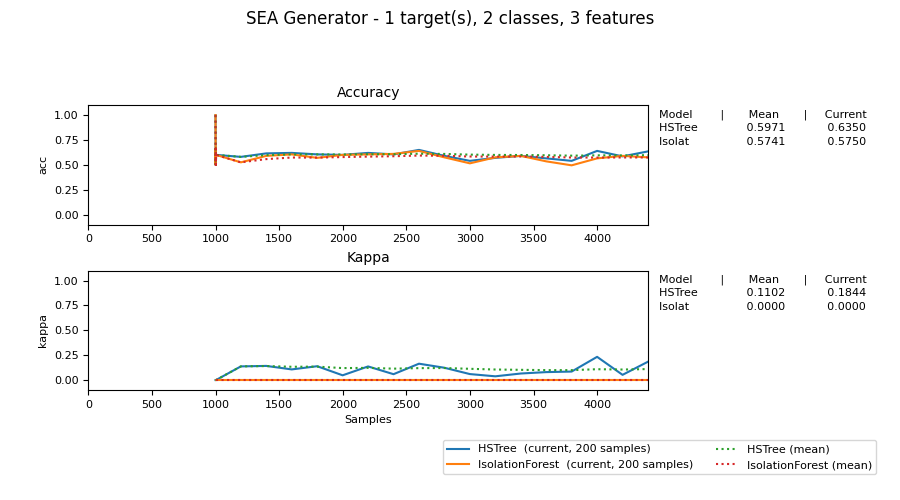

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 ########------------ [40%] [2652.24s]
Processed samples: 4496
Mean performance:
HSTree - Accuracy     : 0.5971
HSTree - Kappa        : 0.1102
IsolationForest - Accuracy     : 0.5741
IsolationForest - Kappa        : 0.0000


[HalfSpaceTrees(anomaly_threshold=0.9, depth=15, n_estimators=50, random_state=5,
                size_limit=10.0, window_size=100),
 IsolationForestStream(anomaly_threshold=0.9, drift_threshold=0.5,
                       n_estimators=50, random_state=None, window_size=100)]

In [19]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
#from skmultiflow.lazy.knn_adwin import KNNAdwin, KNN
#from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream

stream = FileStream('/home/mamadou/big-data/cerin24022022/py-mariambarry/iForestASD_Streaming_Scikit-MultiFlow/Notebook_24032020_2325/datasets/HTTP.csv', n_targets=1, target_idx=-1)
#stream = FileStream('/Users/zhansaya/Downloads/dataset_https.csv', n_targets=1, target_idx=-1)
stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [HalfSpaceTrees(
    #n_features=stream.n_features, 
    window_size=100, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.90,
    depth=15, 
    random_state=5),
     IsolationForestStream(
    window_size=100, n_estimators=50, anomaly_threshold=0.9, drift_threshold=0.5, random_state=None)
    ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=10000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])




## Experiment 3 in the slides : 10000 samples, 500 window_size, 50 estimators

/home/mamadou/.local/lib/python3.8/site-packages/skmultiflow/data/base_stream.py:191: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  warnings.warn(


<IPython.core.display.Javascript object>


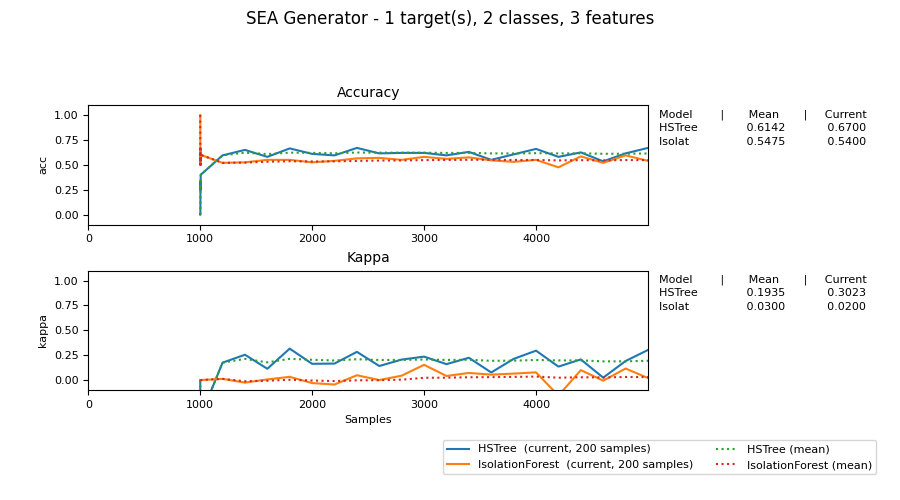

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [4636.63s]
Processed samples: 5000
Mean performance:
HSTree - Accuracy     : 0.6142
HSTree - Kappa        : 0.1935
IsolationForest - Accuracy     : 0.5475
IsolationForest - Kappa        : 0.0300


[HalfSpaceTrees(anomaly_threshold=0.5, depth=15, n_estimators=50, random_state=5,
                size_limit=10.0, window_size=500),
 IsolationForestStream(anomaly_threshold=0.5, drift_threshold=0.5,
                       n_estimators=50, random_state=None, window_size=500)]

In [23]:
%matplotlib notebook
import numpy as np
import pandas as pd
from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.file_stream import FileStream
from skmultiflow.data.data_stream import DataStream
from skmultiflow.data.file_stream import FileStream
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from skmultiflow.trees import HoeffdingTree
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
from skmultiflow.lazy import KNN
#from skmultiflow.lazy.knn_adwin import KNNAdwin, KNN
#from sklearn.linear_model.stochastic_gradient import SGDClassifier
from skmultiflow.data.file_stream import FileStream
import matplotlib as plt
from skmultiflow.data import SEAGenerator
plt.interactive(True)

# 1. Create a stream
## Put the path or real dataset or strem generator
#stream = FileStream('/Users/zhansaya/Downloads/dataset_https.csv', n_targets=1, target_idx=-1)
stream = stream = SEAGenerator(classification_function=0, noise_percentage=0.7, random_state=1)

# 2. Prepare for use
stream.prepare_for_use()
# 2. Instantiate the HoeffdingTree classifier
h = [HalfSpaceTrees(
    #n_features=stream.n_features, 
    window_size=500, 
    n_estimators=50, 
    size_limit=0.1*100, 
    anomaly_threshold=0.5,
    depth=15, 
    random_state=5),
     IsolationForestStream(
    window_size=500, n_estimators=50, anomaly_threshold=0.5, drift_threshold=0.5, random_state=None)
    ]

# 3. Setup the evaluator

evaluator = EvaluatePrequential(pretrain_size=1000, max_samples=5000, show_plot=True, 
                                metrics=['accuracy', 'kappa'], 
                                batch_size=1)
# 4. Run
evaluator.evaluate(stream=stream, model=h, model_names=['HSTree','IsolationForest'])



